**LLM Workshop 2024 by Sebastian Raschka**

This code is based on *Build a Large Language Model (From Scratch)*, [https://github.com/rasbt/LLMs-from-scratch](https://github.com/rasbt/LLMs-from-scratch)

# 4) Pretraining LLMs

In [2]:
!pip install matplotlib

  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 37.6 MB/s eta 0:00:0000:01
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 35.0 MB/s eta 0:00:00


In [3]:
from importlib.metadata import version

pkgs = ["matplotlib", 
        "numpy", 
        "tiktoken", 
        "torch",
       ]
for p in pkgs:
    print(f"{p} version: {version(p)}")

matplotlib version: 3.10.3
numpy version: 2.1.1
tiktoken version: 0.7.0
torch version: 2.7.0


- In this notebook, we implement the training loop and code for basic model evaluation to pretrain an LLM

<img src="figures/01.png" width=1000px>

<br>
<br>
<br>
<br>



# 4.1 Using GPT to generate text

- We initialize a GPT model using the code from the previous notebook

In [5]:
import torch
from supplementary import GPTModel


GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # Disable dropout during inference

- We use dropout of 0.1 above, but it's relatively common to train LLMs without dropout nowadays
- Modern LLMs also don't use bias vectors in the `nn.Linear` layers for the query, key, and value matrices (unlike earlier GPT models), which is achieved by setting `"qkv_bias": False`
- We reduce the context length (`context_length`) of only 256 tokens to reduce the computational resource requirements for training the model, whereas the original 124 million parameter GPT-2 model used 1024 tokens

- Next, we use the `generate_text_simple` function from the previous chapter to generate text
- In addition, we define two convenience functions, `text_to_token_ids` and `token_ids_to_text`, for converting between token and text representations that we use throughout this chapter

<img src="figures/02.png" width=1200px>

In [6]:
import tiktoken
from supplementary import generate_text_simple


def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

In [14]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- As we can see above, the model does not produce good text because it has not been trained yet
- How do we measure or capture what "good text" is, in a numeric form, to track it during training?
- The next subsection introduces metrics to calculate a loss metric for the generated outputs that we can use to measure the training progress
- The next chapters on finetuning LLMs will also introduce additional ways to measure model quality

<br>

<br>
<br>
<br>
<br>



# 4.2 Preparing the dataset loaders

- We use a relatively small dataset for training the LLM (in fact, only one short story)
  - The training finishes relatively fast (minutes instead of weeks), which is good for educational purposes
- For example, Llama 2 7B required 184,320 GPU hours on A100 GPUs to be trained on 2 trillion tokens
 
- Below, we use the same dataset we used in the data preparation notebook earlier

In [15]:
with open("the-verdict.txt", "r", encoding="utf-8") as file:
    text_data = file.read()

- A quick check that the text loaded ok by printing the first and last 100 words

In [16]:
# First 100 characters
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [17]:
# Last 100 characters
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [18]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("Characters:", total_characters)
print("Tokens:", total_tokens)

Characters: 20479
Tokens: 5145


- With 5,145 tokens, the text is very short for training an LLM, but again, it's for educational purposes (we will also load pretrained weights later)

- Next, we divide the dataset into a training and a validation set and use the data loaders from chapter 2 to prepare the batches for LLM training
- For visualization purposes, the figure below assumes a `max_length=6`, but for the training loader, we set the `max_length` equal to the context length that the LLM supports
- The figure below only shows the input tokens for simplicity
    - Since we train the LLM to predict the next word in the text, the targets look the same as these inputs, except that the targets are shifted by one position

<img src="figures/03.png" width=1500px>

In [19]:
from supplementary import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

- We use a relatively small batch size to reduce the computational resource demand, and because the dataset is very small to begin with
- Llama 2 7B was trained with a batch size of 1024, for example

- An optional check that the data was loaded correctly:

In [20]:
print("Train loader:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\nValidation loader:")
for x, y in val_loader:
    print(x.shape, y.shape)

Train loader:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

Validation loader:
torch.Size([2, 256]) torch.Size([2, 256])


- Another optional check that the token sizes are in the expected ballpark:

In [21]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 4608
Validation tokens: 512
All tokens: 5120


- Next, let's calculate the initial loss before we start training

- If you have a machine with a CUDA-supported GPU, the LLM will train on the GPU without making any changes to the code
- Via the `device` setting, we ensure that the data is loaded onto the same device as the LLM model

In [22]:
from supplementary import calc_loss_loader


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device) # no assignment model = model.to(device) necessary for nn.Module classes

torch.manual_seed(123) # For reproducibility due to the shuffling in the data loader

with torch.no_grad(): # Disable gradient tracking for efficiency because we are not training, yet
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("Training loss:", train_loss)
print("Validation loss:", val_loss)

Training loss: 10.98758347829183
Validation loss: 10.98110580444336


<br>
<br>
<br>
<br>



# 4.3 Training an LLM

- In this section, we finally implement the code for training the LLM

<img src="figures/04.png" width=700px>

In [ ]:
from supplementary import (
    calc_loss_batch,
    evaluate_model,
    generate_and_print_sample
)

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # Initialize lists to track losses and tokens seen
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # Main training loop
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # Reset loss gradients from previous batch iteration
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # Calculate loss gradients
            optimizer.step() # Update model weights using loss gradients
            tokens_seen += input_batch.numel()
            global_step += 1

            # Optional evaluation step
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        # Print a sample text after each epoch
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen

- Now, let's train the LLM using the training function defined above:

In [24]:
torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

Ep 1 (Step 000000): Train loss 9.781, Val loss 9.933
Ep 1 (Step 000005): Train loss 8.111, Val loss 8.339
Every effort moves you,,,,,,,,,,,,.                                     
Ep 2 (Step 000010): Train loss 6.661, Val loss 7.048
Ep 2 (Step 000015): Train loss 5.961, Val loss 6.616
Every effort moves you, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and, and,, and, and,
Ep 3 (Step 000020): Train loss 5.726, Val loss 6.600
Ep 3 (Step 000025): Train loss 5.201, Val loss 6.348
Every effort moves you, and I had been.                                            
Ep 4 (Step 000030): Train loss 4.417, Val loss 6.278
Ep 4 (Step 000035): Train loss 4.069, Val loss 6.226
Every effort moves you know the                          "I he had the donkey and I had the and I had the donkey and down the room, I had
Ep 5 (Step 000040): Train loss 3.732, Val loss 6.160
Every effort moves you know it was not that the picture--I had the fact by the last

In [25]:
torch.save(model.state_dict(), "model.pth")

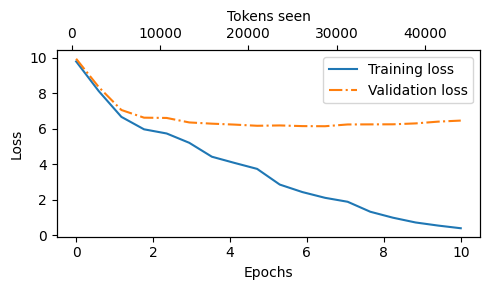

In [40]:
from supplementary import plot_losses


epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- Looking at the results above, we can see that the model starts out generating incomprehensible strings of words, whereas towards the end, it's able to produce grammatically more or less correct sentences
- However, based on the training and validation set losses, we can see that the model starts overfitting
- If we were to check a few passages it writes towards the end, we would find that they are contained in the training set verbatim -- it simply memorizes the training data

- There are decoding strategies (not covered in this workshop) that can mitigate this memorization by a certain degree
- Also note that the overfitting here occurs because we have a very, very small training set, and we iterate over it so many times
  - The LLM training here primarily serves educational purposes; we mainly want to see that the model can learn to produce coherent text
  - Instead of spending weeks or months on training this model on vast amounts of expensive hardware, we load pretrained weights later

<br>
<br>
<br>
<br>



# Exercise 1: Generate text from the pretrained LLM

- Use the model to generate new text (HINT: scroll up to see how we generated text before)

In [33]:
model.eval()
tokenizer = tiktoken.get_encoding("gpt2")
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
start_context = "Hello, what's your name?"
context_size = model.pos_emb.weight.shape[0]
encoded = text_to_token_ids(start_context, tokenizer).to(device)
with torch.no_grad():
    token_ids = generate_text_simple(
        model=model, idx=encoded,
        max_new_tokens=50, context_size=context_size
    )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
print(decoded_text)

cpu
Hello, what's your name? on--forming, as it were, so inevitably the background of the house."

"I didn't about her poverty. Gisburn's open countenance. "It's his ridiculous modesty, you know. He says they're not fit


<br>
<br>
<br>
<br>



# Exercise 2: Load the pretrained model in a new session

- Open a new Python session or Jupyter notebook and load the model there

In [14]:
import torch
import tiktoken
from supplementary import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # Vocabulary size
    "context_length": 256, # Shortened context length (orig: 1024)
    "emb_dim": 768,        # Embedding dimension
    "n_heads": 12,         # Number of attention heads
    "n_layers": 12,        # Number of layers
    "drop_rate": 0.1,      # Dropout rate
    "qkv_bias": False      # Query-key-value bias
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = tiktoken.get_encoding("gpt2")
model.load_state_dict(torch.load("model.pth", map_location=torch.device("cpu"), weights_only=True))
model.eval();  # Disable dropout during inference

In [35]:
generate_and_print_sample(model=model, tokenizer=tokenizer, device=device, start_context="Ello")

Ello the prism of Hermia's tears I felt able to face the fact with equanimity. Poor Jack Gisburn! The women had made him--it was fitting that they should mourn him. Among his own sex fewer regrets were heard, and


<br>
<br>
<br>
<br>


# Exercise 3 (Optional): Train the LLM on your own favorite texts

In [6]:
text = """LESSWRONG
Book Review: On the Edge: The Fundamentals
23rd Sep 2024
Don't Worry About the Vase
The most likely person to write On the Edge was Nate Silver.

Grok thinks the next most likely was Michael Lewis, followed by a number of other writers of popular books regarding people thinking different.

I see why Grok would say that, but it is wrong.

The next most likely person was Zvi Mowshowitz.

I haven’t written a book for this type of audience, a kind of smarter business-book, but that seems eminently within my potential range.

On the Edge is a book about those living On The Edge, the collection of people who take risk and think probabilistically and about expected value. It centrally covers poker, sports betting, casinos, Silicon Valley, venture capital, Sam Bankman-Fried, effective altruism, AI and existential risk.

Collectively, Nate Silver calls this cultural orientation The River.

It is contrasted with The Village, which comprises roughly the mainstream mostly left-of-center institutions, individuals and groups that claim that they are The Experts and the Very Serious People.

If you are thinking about Secret Third Thing, that Village plus River very much does not equal America, I was thinking a lot about that too. Hold that thought.

The book is a collection of different topics. So this review is that, as well.

The central theme here will be Yes, And.

Nate Silver wrote On the Edge for people who are not in The River. I suspect his main target was The Village, but there are also all the people who are neither. He knows a lot more than he is saying here, but it is a popular book, and popular books have to start at the beginning. There was a lot to cover.

This joy of this review? I don’t have to do any of that. This is aimed at those who read things I write. Which means most of you already know a lot, often most, of what is in at least large portions of On the Edge.

So this is a chance to go deeper, be more detailed and opinionated, with a different world model in many ways, and expertise in different spots along the River.

As with my other book reviews, quotes by default are from the book, and the numbers in parenthesis are book locations on Kindle. I sometimes insert additional paragraph breaks, and I fix capitalization after truncating quotes while being careful to preserve original intent. Also notice that I change around the order when it improves flow.

This review is in four parts, which I plan to post throughout the week: The Fundamentals (this post), The Gamblers, The Business and The Future.


Overview
On the Edge is a series of stories tied to together by The River and risk taking.

I see this as a book in four parts, which I’ve rearranged a bit for my review.

This post will cover The Fundamentals: The introduction, the overall concepts of The River and the Village, and various universal questions about risk taking. That includes the book’s introduction, and universal discussions pulled from later on.

Part 1 of the book, which I will cover in the second post The Gamblers, is about the world of gambling. You have poker, sports betting and casinos.

This was my favorite part of the book.

I have some experience with these topics, and got what I would call Reverse Gell-Mann Amnesia.

In normal Gell-Mann Amnesia, you notice the newspaper gets wrong the things you know the most about. Then you go on to not assume that the newspaper is equally inaccurate on other topics.

In reverse Gell-Mann Amnesia, you notice that the book is getting the details right. Not even once, while covering these topics, did I think to myself, ‘oh, that’s wrong, Nate got fooled or confused here.’

Are there places where I would have emphasized different points, taken a different perspective or added more information, or even disagreed? Oh, sure. But I’ve read a lot of this style of book, and Nate Silver definitely Gets It. This is as good as this format allows.

Drayton’s review found Nate making a number of ‘elementary’ mistakes in other areas. And yes, once you get out of Nate’s wheelhouse, there are some errors. But they’re not central or importantly conceptual, as far as I could tell.

Part 2 of the book, which I will cover in what I’ll call The Business, was about gamblers who play for higher stakes over longer periods, betting on real world things. As in, we talk about stock traders, Silicon Valley and venture capital. I think that the spirit is largely on point, but that on many details Nate Silver here buys a bit too much into the insider story that gets pitched to him and other outsiders, in ways that assume the virtues of good gamblers and The River are present to a greater extent than they are. They’re there, but not as much as we’d like.

Part 3 of the book, which I will also include in The Business, was about crypto and especially Sam Bankman-Fried. This part was a let down, and I’m mostly going to skip over it. On basic crypto my readers know all this already.

After Going Infinite and my review of that, it did not feel like there was much to add on SBF. I worry this tied presented SBF as more central and important to The River and especially to EA and similar areas than he actually was. I do get why Nate Silver felt he had to cover this, and why he had to run with it once he had it. We’ll hit some highlights that are relatively unique, but mostly gloss over it.

Part 4 of the book, which I will cover in The Future, was about AI and existential risk, including rationalists and EAs. He picks excellent sources: Sam Altman, Roon, Ajeya, Scott Alexander, Oliver Habryka, Eliezer Yudkowsky. He also talked to me, although I did not end up being quoted.

The parts that discuss the history of OpenAI reflect Silver essentially buying Altman’s party line in ways I found disappointing. I will do my best to point to my corrections of the record and distinctions in perspective.

The parts that talk about AI technically will be nothing new to blog readers here. I don’t think he got anything wrong, but we will mostly skip this.

Then there is the discussion of AI existential risk, and the role of the EA and rationalist communities. While I was disappointed, especially after the excellent start, I totally see how Nate got where he ended up on all this. It was a real outsider attempt to look at the situation, and here I can bring superior knowledge and arguments to bear.

Nate’s overall view, that existential risk is obviously real and important if you think AI is going to keep advancing, but that we cannot at this time afford to simply choose not to proceed, seems incomplete but eminently reasonable. Long book is long, and necessary background information is a big problem, but the discussion of existential risk arguments felt extremely abrupt and cut off, in ways the rest of the book did not. In contrast, he spends a bunch of time arguing we should worry about technological stagnation if we do not proceed with AI.

One thing about the final section I loved was the Technological Richter Scale. This was very good Rhetorical Innovation, asking people to place AI on a logarithmic scale of impact compared to other technologies. This reveals better than other methods that many, perhaps most, disagreements about AI existential risk are actually disagreements about AI capabilities – those not worried about AI largely do not believe AI will be ‘all that.’ I covered the scale in its own post, so it will have its own reference point.

Introduction: The River
What is The River?

Every book like this needs a fake framework, a new set of categories to tie together chapters about various topics, that then they see everywhere.

What is The River?

The River is a sprawling ecosystem of like-minded people that includes everyone from low-stakes poker pros just trying to grind out a living to crypto kings and venture-capital billionaires. It is a way of thinking and a mode of life. People don’t know very much about the River, but they should.

Most Riverians aren’t rich and powerful. But rich and powerful people are disproportionately likely to be Riverians compared to the rest of the population. (73)

The River Nature is a way of thinking and a mode of life.

If you have that nature by default, you are a Riverian, a citizen of the The River.

If your group or activity rewards and celebrates that nature, then it is along The River.

In this mode, you think in terms of probabilities and expected value (EV). You seek the most accurate possible model of the world, including what actions are how likely to lead to what results. You the riverian look to make the best decisions possible. You are not afraid of risk, but seek to take only the good risks that are +EV.

You can then be somewhat risk averse when making decisions, risk neutral or even risk loving. All riverians have weaknesses, ways they systematically mess up. The key is, you accept that risk is part of life, and you look to make the most of it, including understanding that sometimes the greatest risk is not taking one.

Riverians are the Advantage Players of life.

They want life to be about everyone making good decisions. A True Riverian learns to inherently love a correct play and hate a mistake, in all contexts, from all sides that are not their active opponents. They want those good decisions and valuable actions to be rewarded, the bad decisions and destructive actions punished. They want that to be what matters, not who you know or who you are or how you play some political game.

Riverians hate being told what to do if they don’t think it will help them win. They despise when others boss them around and tell them to do dumb things, or are told to copy what others around them do without justification.

The River is where people focus on being right, taking chances and doing what works, and not letting anyone tell them different.

As you would expect, The River and its inhabitants often looks stupid. Things are reliably blowing up in various faces and others, especially The Village, are often quick to highlight such failures.

Given everything that took place while I was writing this book—poker cheating scandals; Elon Musk’s transformation from rocket-launching renegade into X edgelord; the spectacular self-induced implosion of Sam Bankman-Fried—you’d think the River had a rough few years. But guess what: the River is winning. (77)

Few would accuse Elon Musk or SBF of being the innocent victims of bad luck regarding recent events in their lives. Mistakes, as they say, were made. Massive, historical mistakes. But the alternative, the world and culture and nature where such mistakes are not happening, where people don’t take successful risks and then get into position to take even bigger ones, is worse, not better.

As a fellow inhabitant of The River, this one rings far more true and important than most. I am definitely convinced the River is real, and that it definitely includes most of the groups listed in the book, although we’ll see there is one case I think is less clear.

One very clear truth is that playing poker or betting on sports is Not So Different from investing in tech startups or investing (sometimes ‘investing’) in crypto tokens.

The River isn’t all fun and games. The activities that everyone agrees are capital-G Gambling—like blackjack and slots and horse racing and lotteries and poker and sports betting—are really just the tip of the iceberg. They are fundamentally not that different from trading stock options or crypto tokens, or investing in new tech startups. (94)

If you had to divide that collection into two groups, you could divide it into the casino gambling on one side and the ‘investments’ on the other, and that would be valid.

Almost as valid would be to move poker and sports betting and other skill games into the ‘investment’ category, and leave slot machines and craps and other non-skill games in the other (with the exception of a small number of Advantage Players, which the book explores). In practice, a zero-day stock option is closer to a sports bet than it is to buying the stock and holding it for a month. More on that throughout.

There is quite a lot of that actual straight up gambling.

Literal gambling is booming. In 2022, Americans lost around $60 billion betting at licensed casinos and online gambling operations—a record even after accounting for inflation. They also lost an estimated $40 billion in unlicensed, gray-market, or black-market gambling—and about $30 billion in state lotteries. To be clear, that’s the amount they lost, not the amount they wagered, which was roughly ten times as much. (188)

A total of $130 billion means the average adult lost on the order of $500 gambling, but of course that is wildly unevenly distributed. Most lost nothing or very little. A few lost a lot.

The multiplier depends on the game. A 10x multiplier for casinos and grey market gambling seems reasonable.

For state lotteries, the multiplier is… less.

On average, the government keeps about 35 cents of every dollar you spend on a lottery ticket, and some states keep 80 percent or more. Lottery tickets are purchased disproportionately by the poor. (2871)

As the game Illuminati describes the state lottery, it’s a tax on stupidity, and the money rolls in. That is unfair. Slightly. Only slightly. It is absurd how terrible the official lotteries are.

Nate Silver Comes Home to The River
There is nothing like being where you belong to remind you who you are, as Nate experienced after going to his first real poker tournament after Covid.

The other big realization I had on that flight home from Florida was that this world of poker players and poker-playing types—this world of calculated risk-taking—was the world where I fit in. (206)

And yet, the people in the River are my tribe—and I wouldn’t have it any other way. Why did my conversations flow so naturally with people in the River, even when they were on subjects I was still learning more about? (378)

Why indeed? Why does he think he fits in so well?

First, there’s what I call the “cognitive cluster.” Quite literally: How do people in the River think about the world? It begins with abstract and analytical reasoning. (387)

The natural companion to analytic thinking is abstract thinking—that is, trying to derive general rules or principles from the things you observe in the world. Another way to describe this is “model building.” (391)

Then there’s the “personality cluster.” These traits are more self-explanatory. People in the River are trying to beat the market. (422)

Relatedly, people in the River are often intensely competitive. (430)

Finally, I put risk tolerance in this cluster because—whether they’re degens or nits in other parts of their lives—being willing to break from the herd and go against the consensus is certainly not the safest professional path. (436)

Nate’s history is that he was a poker player, happily minding his own business, then Congress sneaked a provision into a bill that killed American online poker and took away his job.

There was one silver lining: the UIGEA piqued my interest in politics. The bill had been tucked into an unrelated piece of homeland security legislation and passed during the last session before Congress recessed for the midterms. It was a shifty workaround, and having essentially lost my job, I wanted the people responsible for it to lose their jobs, too. (235)

I have a deeply similar story, with sports betting and the Safe Port Act. Congress tucks a provision into a different law and suddenly online sports betting transforms and being a sports better in America became vastly more difficult. Both of us got fired.

Nate went into politics. I chose a different angle of response. We both did well in our new modeling work, and then both got frustrated over time.

In Nate’s case, the problem was that election forecasts and regular people don’t mix.

But here’s the thing about having tens of millions of people viewing your forecast: a lot of them aren’t going to get it. (246)

Expected value is such a foundational concept in the River’s way of thinking that 2016 served as a litmus test for who in my life was a member of the tribe and who wasn’t. At the same moment a certain type of person was liable to get very mad at me, others were thrilled that they’d been able to use FiveThirtyEight’s forecast to make a winning bet. (267)

But permit me this one-time informal use of “rational”: people are really fucking irrational about elections (308)

Likewise, the tendency in the media is to contextualize ideas—The New York Times is no longer just the facts, but a “juicy collection of great narratives,” as Ben Smith described it. (420)

In my case, those I worked with declared (and this is a direct quote) ‘the age of heroes is over,’ cut back on risk and investment accordingly, and I wept that this meant there were no more worlds to conquer. So I left for others.

We are both classic cases of learning probability for gambling reasons, then eventually applying it to places that matter. It is most definitely The Way.

Blaise Pascal and Pierre de Fermat developed probability theory in response to a friend’s inquiry about the best strategy in a dice game. (367)

Nate (In General) Makes One Critical Mistake
He notices, but he can’t stop himself.

I feel like it’s my sacred duty to call out someone who’s wrong on the internet. (6417)

I indeed see him doing this a lot, especially on Twitter. Nate Silver, with notably rare exceptions, you do not have to do this. Let it go.

The Village Idiots
There’s also another community that competes with the River for power and influence. I call it the Village. (440)

The Village are the Respectable Authority Figures. The Very Serious People.

It consists of people who work in government, in much of the media, and in parts of academia (although perhaps excluding some of the more quantitative academic fields such as economics). It has distinctly left-of-center politics associated with the Democratic Party. (442)

My title for this section is not entirely fair to The Village. It is also not as unfair as it sounds. Members of The Village are usually above average in intelligence and skill and productivity. The vast majority of people are not in either Village or River.

But yeah, in the ways Village and River differ strongly? I mostly stand by it. The failure to use the River Nature, the contrast in modes of cognition, is stupefying.

In some contexts, those not in The Village proper will attempt to play the role of The Village in a given context. In doing so, they take on The Village Nature, to attempt to operate from that same aura of authority and expertise. And yes, it reliably makes them act and talk stupider.

What makes people far stupider than that is being trapped in the Hegelian dialectic, and in particular the one of party politics.

Indeed, Riverians inherently distrust political parties, particularly in a two-party system like the United States where they are “big tent” coalitions that couple together positions on dozens of largely unrelated issues. Riverians think that partisan position taking often serves as a shortcut for the more nuanced and rigorous analysis that public intellectuals ought to engage in. (466)

That is Nate Silver bending over backwards to be polite. Ask most members of The River, whether they back one party, the other or neither, and they will say something similar that is… less polite.

The Village also believes that Riverians are naïve about how politics works and about what is happening in the United States. Most pointedly, it sees Donald Trump and the Republican Party as having characteristics of a fascist movement and argues that it is time for moral clarity and unity against these forces. (510)

The Village thinks that if you do not give up your epistemics to support their side of the Hegelian dialectic, then you lack moral clarity and are naive. No, that claim did not start with Donald Trump. Nor is it confined to The River.

Riverians are fierce advocates for free speech, not just as a constitutional right but as a cultural norm. (488)

To the extent they express an opinion on the issue, whether or not they belong to The River, every single person whose opinion I respect is a strong advocate for free speech.

I remember when I thought The Village believed in free speech too. No longer. Some members of The Village do. Overall it does not.

That is a huge problem. The Village that exists today is very different from The Village that my parents thought they were members of back in the day. I would still ultimately have the River Nature, but I miss the old Village.

Alone in the Wilderness
I buy that there exist The River and The Village.

What about everyone and everything else?

This becomes most obvious when the book or author discusses Donald Trump.

Obviously Donald Trump is not of The Village.

The temptation is to place him in The River, but that is also obviously wrong.

Donald Trump may have an appetite for some forms of risk and even for casinos, but he does not have The River Nature. He does not think in probabilities and expected values. He might want to run a casino, but that is because he was in the real estate business, not because he has any affinity for River-style gamblers.

If you look at Donald Trump’s supporters, it becomes even clearer. These people hate The Village, but most also view The River as alien. They don’t think in probability any more than Villagers do. When either group goes to a casino, almost none of them are looking for advantage bets. They, like most people and perhaps more so, are deeply suspicious of markets, and those who speak in numbers and abstractions.

The Village might be in somewhat of a cold war with The River, but the River is not its natural enemy or mirror. Something else is that.

So what do we call this third group? Not ‘everyone not in the Village or River’ and not ‘the other political party’ but rather: The natural enemies of The Village?

I asked for the LLM consensus is in, and there is a clear winner that I agree is indeed this group’s True Name in this schema, that works on many levels: The Wilderness.

In the extended metaphor, it used to be that Village and River were natural allies. Now that this is not the case. The Village presents the world as a Hegelian dialectic between it and the Wilderness, treating every other group including the River as irrelevant or some side show.

Their constant message to the River is: You don’t f***ing matter. Their other message is that they do not tolerate neutrality. When the Village turns on you and yours for not falling in line – and the River Nature as a matter of principle does not bow down, which is a big hint as to who they centrally are – but especially when the Village turns directly on you, you feel cast out and targeted.

Thus, increasingly, some members of The River, and others who The Village casts out over some Shibboleth, end up in The Wilderness. This is a deeply tragic process, as they abandon The River Nature and embrace The Wilderness Nature, inevitably embracing an entire basket of positions, usually well past the point of sanity.

See: Elon Musk.

Does that still leave a Secret Fourth Thing?

One can of course keep going.

Most people, even if they ‘put their trust in’ the Village, Wilderness or River, or even The Vortex. They do not at core have any of these natures. They are good people trying to go about their business in peace. One can call this The People.

(Note: I tried to make this fit the Magic color wheel in a fun way, but it didn’t work.)

An alternative telling here in another good book review suggests The Fort as the right-wing mirror image of The Village. The Fort is where Ted Cruz and Samuel Alito hang out. It’s important to note that The Wilderness and The Fort are not the same place. And we both agree that The People are a distinct other thing.

Why the River Hates the Village
The actual section is actually “Why the Valley Hates the Village (4756)” but this is one case where I think one can push the book thesis further. Yes, centrally Silicon Valley, but the entire River hates the Village, mostly for the same underlying reasons.

Those reasons, centrally, are in my own words something like this:

The Village in many ways does mean well.

But it fundamentally views the world as a morality play and Hegelian dialectic. The us against the them. ‘Good causes’ to advance against enemies like ignorance and greed. Those ‘good causes’ and their Shibboleths are often chosen based on what feels good to endorse on a surface level, rather than what would actually do good. Often they get hijacked by various social dynamics spun out of control, often caused by people who do not mean well. They rarely ask deeply about the effectiveness of their proposals.

Not only do they think this is going on, they think it is the only important thing going on. And they think primarily on Simulacra level 3, in terms of alliances and implications and how things sound about saying what type of person you are and are allied with, rather than about what actually causes what.

When they lie or break the rules or the norms of common decency it is for a good cause. When others do it they cry bloody murder. And they justify all that by pointing at The Wilderness and saying, have you seen The Other Guys? As if there were only two options.

They have never understood economics and incentives and value creation, or trade-offs, treating you as a bad person if you point out or care about such considerations. They treat your success and your wealth and legacy as fundamentally not yours, and think they have a right to take it from you, and that not doing so would be unfair. They have great respect for certain particular local details that made their Shibboleth and Good Cause lists, while completely ignoring vital others and Seeing Like a State.

Indeed, if you have other priorities than theirs, if you break even one of their Shibboleths or triggers, or fail to sufficiently support the wrong one at the wrong time, they often cast you out into The Wilderness, doing their best to have people place you there regardless of whether that makes any sense. And the resulting costs, in the form of the inability to Do Things of various sorts, is growing over time, to the point where our civilization is in rather deep trouble.

To be fair, trust in Big Tech has also dropped sharply in polls. But Silicon Valley is not particularly dependent on public confidence so long as it continues to recruit talent and people continue to buy its products. (5268)

Big Tech now sees the specter of actively dangerous enemy action. So does what Marc Andreessen calls ‘Little Tech.’ So does the rest of The River.

The River, in the past, mostly put up with The Village. The Village has a lot of practical advantages, did broadly mean well, and there were common enemies who were seen as clearly worse. And importantly, The Village was mostly leaving The River alone in kind, or at least giving it some space in which to safely operate, and the paralysis effects were nowhere near as bad.

Starting around 2016, a lot of that changed, and other parts reached tipping points. Also they blew their remaining credibility and legitimacy in increasingly stupid ways, cumulating in various events around the time of Covid. The Village’s case for why The River should accept its authoriah is down to a mix of ‘we have the legible expert labels and are Very Serious People’ and ‘you should see The Other Guy (e.g. The Wilderness’). Both are increasingly failing to hold water.

The first because lol. The second because at some point that’s a risk people in The River will be willing to take. Also decision theory says you can’t let them play you like that indefinitely. We can’t let the Hegelian dialectic win.

There was a deal, well beyond how media coverage works. The Village broke the pact.

This deal’s getting worse and worse all the time. The rent got too damn high.

Nate Silver’s History of River Versus Village
Everyone got really mad at each other about 2016. (4762)

That was a big breaking point. Meta is awful, Facebook is awful, Mark Zuckerberg is awful, and also their AI positions might well doom us all. But the story that a few Facebook ads were why Trump beat Hillary Clinton in 2016 was always absurd.

And yet, that became The Narrative, in many circles. That had big effects.

One that Nate doesn’t focus on is Gell-Mann Amnesia. If The Experts are so convinced of something like this, that is clear Obvious Nonsense, what else that they tell you is Obvious Nonsense?

Another is that Big Tech, and tech in general, got a clear lesson in the Copenhagen Interpretation of Ethics. If tech is seen interacting with something, they were informed, then tech will be blamed for the result. Which, given how much tech interacts with everything, is a real problem.

Patrick McKenzie has noted that one big result of this was that when we got a Covid vaccine, we had a big problem. Rather than reach out for Google’s help, the government tried to muddle through without it. Google and Apple and Amazon did not dare step forward and offer help in getting shots into arms, for fear of blowback. Even if they got it right, they feared they would be showing up the government.

That is how a handful of volunteers on a Discord server, VaccniateCA, ended up becoming our source of information on the vaccine.

The Village is about group allegiance, while Silicon Valley is individualistic. (4782)

The Village really is about group allegiance, and also increasingly (at least until about 2020) group identity. Which groups and ideas you are for, which ones you are against. They are centrally Simulacra Level 3, although they also spend time at 1, 2 and 4.

The River is individualistic, as Nate says, but even more it is about facts and outcomes and ground truth: Simulacra Level 1. Most River factions are very Level 1 focused.

Silicon Valley is the major part of the River that compromises on this the most. They talk about the importance of Level 1, ‘build something people want.’ Yet they are very willing to care deeply about The Vibes, and often primarily operate more on Level 4 (and at times the Level 4 message is exactly that you too should be doing this), as well as some of Levels 2 and 3. A certain amount of lying, or at least selective presentation, is expected, as is loyalty to the group and its concepts. It’s complicated.

Meritocracy is another big deal for The River. Back in the day they could tell the story that The Village was that way too, but that story got harder to tell over time.

Especially in explicit politics, it was clear that merit was going unrewarded.

But campaigns are not always very meritocratic. “It’s very rare to actually be able to assess whether someone did a good job,” Shor said. Campaigns have hundreds of staffers and ultimately only one real test—election night—of how well they did, which is often determined by circumstances outside the campaign’s control. Relationships matter more than merit. So people get ahead by going with the program. (4790)

Extreme merit still gets rewarded, if you have a generational political talent. In the absence of that, the variance overwhelms skill, so politics rules politics.

There are turf wars—and philosophical ones—between Silicon Valley and Washington over regulation. (4801)

This is natural and expected. To some extent everyone is fine with it. The problem is that there are signs this may be taken way too far, in ways that kill or severely damage the Valley’s business model. See the proposals for unrealized taxes on capital gains, for various crazy things that almost get done with social media, and now various claims about AI.

Silicon Valley is skeptical of the “trust the experts” mantra that the Village prizes. (4832)

Skeptical is a nice word for how The River views this by default, in worlds where the experts are plausibly trustworthy. Then various things happened, and kept happening. Increasingly, ‘trust the experts’ became an argument from authority, and from status within the Village, and its mask as a ‘scientific consensus’ resulting from truth seeking became that much harder to maintain.

Tech leaders are in an ideological clash with their employees and blame the Village for it. (4855)

Yes. Yes, they do. It is not a reasonable way to look at the situation, which involved things such as:

In Silicon Valley, you’re supposed to feel like you have permission to express unpopular and possibly quite wrong or even stupid ideas. So Damore’s firing represented a shift. (4878)

The Village created a social climate, especially among tech employees, where Google felt forced to fire Damore and engage in other similar actions, as did many other tech companies. Based on what I have heard, in many places including Google things got very out of hand. This did not sit well.

But what about Silicon Valley’s elites—the top one hundred VCs, CEOs, and founders? There’s no comprehensive catalog of their political views, so I’ll just give you my impressions as a reporter who’s had a variety of conversations with them.

It’s worth keeping in mind that rich people are usually conservative. If Silicon Valley’s elites were voting purely with their pocketbooks, they’d vote Republican for lower taxes and fewer regulations, especially with Khan heading the FTC. (4862)

The elites for a while faced sufficient pressure from the Village, and especially from their employees, they did not dare move against the Village and felt like they were being forced to abandon many core River values and to support democrats despite the financial problems with that and the constant attempts by the Village to attack the SV elites, lower their status and potentially confiscate their wealth and break up their businesses and plans. Recently that danger and fear of ideological backlash has subsided, everyone is sufficiently fed up and worried about actual legal consequences, and feels like the masks are already off, and so there is a lot more open hostility.

Another classic clash point was Thiel getting his revenge on Denton for outing Thiel.

I asked Thiel about this passage. Hadn’t he been a hypocrite to focus on destroying a rival, Denton, half a continent away in New York in a completely unrelated business, all for the sin of outing a gay man who lived in the world’s gayest city, San Francisco?

Thiel quickly conceded the point. “In any intensely competitive context, it is almost impossible to simply focus on a transcendent object and not spend a lot of time on the personalities of one’s rivals.” (4900)

I think it is highly rational and reasonable decision theory to retaliate for that, even if you think everything turned out fine for Thiel after being outed. If someone hits you like that, they are doing it in part because they don’t think you’ll hit back, and others are watching and asking the same question. It is +EV to make everyone think twice, and especially to in advance be the type of person who would do that, especially in a way others can notice. Which Thiel very much was, but Denton didn’t pay enough attention, or didn’t care, so he found out.

One thing that did not ring true for me at all was this:

I asked Swisher why tech leaders like Thiel and Musk are so obsessed with their media coverage. She didn’t need much time to consider her answer. “It’s because they’re narcissists. They’re all malignant narcissists,” she said. (4908)

I’ve long had to mute Kara Swisher. She is constantly name calling, launching unfounded personal attacks and carrying various people’s water, and my emotional state reliably got worse every time I saw anything she wrote without providing me with useful information. She is not a good information source, and this type of comment is exactly why.

Yes, they care about their image, but their image is vital to their business and life strategy. I never got this sense from Thiel at all, and I don’t have any info you don’t have about Musk but certainly he cares far more than most people about big abstract important things, even when I think he’s playing badly.

Spending Time at Airports
A toy risk question that came up later, to get us started.

SBF then made an analogy that you’d think would trigger my sympathies—but actually raised my alarm. “If you’re making a decision, such as there’s no way that it goes really badly, then I sort of feel like—you know, zero is not the correct number of times to miss a flight. If you never miss a flight, you’re spending too much time in airports.”

I used to think about air travel like this. I even went through a phase where I took a perverse joy in trying to arrive as close to the departure time as possible and still make the flight.

Now that I’m more mature and have a credit card that gives me access to the Delta Sky Club, I don’t cut it quite so close. But the reason you should be willing to risk missing a flight is because the consequences are usually quite tolerable. (6033)

A fun tip I recently realized is that if you never miss a flight, that generally means you are spending too little time at airports.

Explanation: If you actual never miss a flight that means you don’t fly enough, since no amount of sane buffer gets your risk anywhere near zero, airlines be tripping.

On the practical question, the key indeed is that there is limited upside and limited downside. This can and should be a calculated risk. Missing your flight is sometimes super expensive, sometimes trivially cheap – there are times you’ll take a $500 buyout to skip the flight happily (although note to airlines: You’ll get a much better price off me if you ask me before I head to the airport!), others where even for thousands the answer is a very clear no.

And there are times when leaving an extra two hours at the airport is a trivial cost, you weren’t doing anything vital and have plenty of good podcasts and books. Other times, every minute before you leave is valuable. And also there are considerations like lounge access.

I don’t have lounge access, but I’ve found that spending time at airports is mostly remarkably pleasant. You have power, you have a phone and if you want a laptop and tablet, there’s shops and people watching, it’s kind of a mini-vacation before the flight if you have a good attitude. If you have an even better attitude, so is the flight.

You would not, however, say ‘if you are still alive you are not doing enough skydiving.’

(Or that you are not building sufficiently advanced AIs, but I digress.)

The Coin Flip
If your decision is very close, why not randomize? Nate does this often, to his partner’s frequent dismay.

We’re indifferent between the Italian place and the Indian place, there’s no reason to waste our time agonizing over the decision. (1049)

I agree I should do this more. Instead, I try to use semi-random determinations, with the same ‘if I made a big mistake I will notice and fix it, and if I made a small mistake who cares’ rule attached.

However I also do frequently spend more time on close decisions. I think this can be good praxis. It is wasteful in the moment, but going into detail on close decisions is a great way to learn how to make better decisions. So in any decision where it would be great to improve your algorithm, if it is very close, you might want to overthink things for that reason.

At other times, yeah, it doesn’t matter. Flip that coin.

The Other Risk Takers
The thesis is that wherever you find highly successful risk takers, you see the same patterns, the same River Nature.

[Those are] hardly the only people who undertake risks. So I want to introduce you to five exceptional people who take physical risks: an astronaut, an athlete, an explorer, a lieutenant general, and an inventor. (3925)

The thesis: If you want to succeed at risk taking, you need to be Crazy Prepared. You need to take calculated risks with your eyes open. You need the drive to succeed enough to justify the risks. You need all the good things.

Even if they aren’t quantitative per se, they are highly rigorous thinkers, meticulous when it comes to their chosen pursuit. One thing’s for sure: our physical risk-takers are definitely not part of the Village. (3934)

Successful risk-takers are cool under pressure. They don’t try to be heroes, but they can execute when the chips are down. (3988)

Successful risk-takers have courage. They’re insanely competitive and their attitude is: bring it on. (4013)

Successful risk-takers have strategic empathy. They put themselves in their opponent’s shoes. (4035)

Successful risk-takers are process oriented, not results oriented. They play the long game. (4067)

Successful risk-takers take shots. They are explicitly aware of the risks they’re taking—and they’re comfortable with failure. (4098)

Successful risk-takers take a raise-or-fold attitude toward life. They abhor mediocrity and they know when to quit. (4127)

Successful risk-takers are prepared. They make good intuitive decisions because they’re well trained—not because they “wing it.” (4171)

Successful risk-takers have selectively high attention to detail. They understand that attention is a scarce resource and think carefully about how to allocate it. (4193)

Successful risk-takers are adaptable. They are good generalists, taking advantage of new opportunities and responding to new threats. (4230)

Successful risk-takers are good estimators. They are Bayesians, comfortable quantifying their intuitions and working with incomplete information. (4252)

Successful risk-takers try to stand out, not fit in. They have independence of mind and purpose. (4284)

Successful risk-takers are conscientiously contrarian. They have theories about why and when the conventional wisdom is wrong. (4306)

Successful risk-takers are not driven by money. They live on the edge because it’s their way of life. (4350)

Is it true that (most) successful risk-takers are not driven by money? Is that in any way in opposition to the edge being a way of life? In the end, most people are in key senses not driven by money. The money is either the means to an end, or it is ‘the score.’ But money is still highly motivational, as that means to an end or as that score. Was SBF motivated by money, or not? What’s the difference?

Of all these, I’d say the most underappreciated is being process oriented. Missing that will get you absolutely killed.

Whereas, as we see when we get to Silicon Valley, being unaware of the risks or odds can kind of work out in some situations. So can, as we see with the astronaut, not being contrarian.

So for example on a spacecraft:

On the Blue Origin orbital spacecraft. Vescovo, who is also a former commander in the U.S. Navy Reserve, told me that the mentality required in exploration, the military, and investing is more similar than you might think. “It’s risk assessment and taking calculated risks,” he said. “And then trying to adapt to circumstances. I mean, you can’t be human and not engage in some degree of risk-taking on a day-to-day basis, I’m just taking it to a different level.” (3983)

Or for a pilot, fictional bad example edition:

What most annoyed Vescovo about Top Gun: Maverick was Tom Cruise’s insistence that you should just trust your gut and improvise your way out of a hairy situation. “The best military operations are the ones that are very boring, where things go exactly according to plan. No one’s ever put in any danger,” he said. “You want to minimize the risks. And so yeah, Top Gun, it looked great on film. But that is not how you would try and take out that target.” (4172)

I haven’t seen Top Gun: Maverick, but you don’t have to in order to understand.

So is there never a place for trusting your gut? That’s not quite what Vescovo is saying. Rather, it’s that the more you train, the better your instincts will be. “When something is for real and is an emergency, how many times have you heard people say, ‘Oh, you know, the training kicked in.’ ” Training, ironically, is often the best preparation to handle the situations that you don’t train for. (4180)

The problem with Top Gun: Maverick wasn’t with Maverick—his instincts probably were pretty good—but that he was imploring other pilots to trust their gut and be heroes when they didn’t have the same experience base. (4191)

Yep. The way you trust your gut and improvise well is to be Crazy Prepared. Then you have a gut worth trusting. You can’t give that advice to people before they’re ready, and people often do it and cause a lot of damage or failure.

“The best players will study solvers so much that their fundamentals become automatic,” he wrote—the complex System 2 solutions that computers come up with make their way into your instinctual System 1 with enough practice. That frees up mental bandwidth for when you do face a hairy situation, or a great opportunity. (4187)

That’s how the true masters do it. The less you have to think about the basics, the more they’re automatic, the more you can improve other stuff.

Exactly in the Magic competitions where I was Crazy Prepared I was able to figure out things under the lights I’d never considered in practice – for example in my victory in Tokyo, I’d not once named Nightscape Familiar on a Meddling Mage in all of practice, or named Green for Voice of All without a Crimson Acolyte against Red/Green, or even considered cutting Fact or Fiction while sideboarding. Winning required, as it played out, that I figure out to do all three.

Who would take the risks without the pressure?

Karikó found it more in the United States than in Communist-era Hungary. “If I would stay in Hungary,” she told me,[*6] “can you imagine I would go and sleep in the office?” In the United States, she found “the pressure is on in different things, so that is why it’s great.” (4029)

For me the answer is that you can sort of backdoor into situations where the risks are so overwhelmingly +EV that you have no choice but to take them, and you have the security of knowing you have a safety net if you need one – I was never worried I would end up on the street or anything, I could always get a ‘real job’ (as I did at Jane Street), learn to code (well enough to earn money doing it) or even play poker.

Aside on Covid
In so many ways, our civilization handled Covid rather badly. Nate identifies correctly one of the two core mistakes, which was that it was a raise-or-fold situation, and we called, trying to muddle through without a plan.

I’d argue, for instance, that the world might have been better off if it treated the COVID-19 pandemic as a raise-or-fold situation. (4148)

The few countries like New Zealand and Sweden that pursued more coherent strategies—essentially, New Zealand raised and Sweden folded—did better than the many that muddled through with a compromise approach. (4150)

This is essentially correct for the pre-vaccine period. Raising and folding were both reasonable options. The strategy we chose was neither, and we executed it badly, aside from (by our standards) Operation Warp Speed.

The other core mistake was botched execution at every step. That’s another story.

What is a Contrarian?
What I think of as ‘contrarian’ Nate calls ‘independent’ here?

There is an oft-neglected distinction between independence and contrarianism. If I pick vanilla and you pick chocolate because you like chocolate better, you’re being independent. If you pick chocolate because I picked vanilla, you’re being contrarian.

Most people are pretty damned conformist—humans are social animals—and Riverians are sometimes accused of being contrarian when they’re just being independent. If I do the conventional thing 99 percent of the time and you do it 85 percent of the time, you’ll seem rebellious by comparison, but you’re still mostly going with the flow. (4307)

This is in opposition to Nate saying ‘successful risk-takers are conscientiously contrarian.’ Successful risk-takers are being, by this terminology, independent.

On the (OF COURSE!) contrary, I think of this very differently. Being ‘a contrarian’ means exactly what Nate calls independent here: Being willing to believe what seems true, and do what you prefer, and say it out loud, exactly because you think it is better.

Most people are, most of the time, rather unwilling to do this. Even when they disagree or do something different, they are still following the script.

Yes, they will sometimes pick chocolate over vanilla despite you picking vanilla. At other times, they will pick chocolate over vanilla in part because you picked vanilla… because it is standard to not order the same thing at the same time, so also picking literal vanilla would actually in many cases be contrary and independent. But they’ll still look for chocolate, not the weird sounding flavor they actually like and want, if they can make it work – which is similar to how those pushed out of The Village end up in The Wilderness (or Vortex), rather than in The River or doing some secret third thing (I think on reflection the secret thing is kind of Always Third, even if it’s not?).

Someone who actually does unconventional things 15% of the time is a world-class rogue actor. You may think that someone (let’s say Elon Musk) is doing tons of unconventional stuff and is totally out in space, but when you add it all up he’s still on script something like 99% of the time. The difference is 99% versus 99.9%, or 99.99%.

Which is smart. The script isn’t stupid, you shouldn’t go around breaking it to break it, and if you broke it 15% of the time you would, as they say, Find Out. When we say 85%, we mean that 15% of the time Elon is doing some aspect of the thing differently.

After all, when you order the Cinnamon Toast ice cream, it’s still ice cream, and you are probably still putting it in a cup or cone and eating it, and so on.

What Nate Silver is calling ‘contrarian’ here is what I’d call ‘oppositional.’ It is the thing where Your Political Party says ‘I think apple pie is good’ and Their Political Party says ‘well then I suppose apple pie is bad.’

Prediction Market Smackdown
I’m going to finish the introduction with Nate’s discussion of prediction markets.

Nate Silver, now advisor to Polymarket, is definitely a prediction market fan.

He still has reservations, because he has seen their work.

My views are mostly sympathetic, but not without some reservations. That’s in part because of some scar tissue from too many arguments I’ve had on the internet about the accuracy of prediction markets versus FiveThirtyEight forecasts. The FiveThirtyEight forecasts have routinely been better—I know that’s what you were expecting me to say, but it’s true—something that’s not supposed to happen if the markets are efficient.

Then again, maybe this doesn’t tell us that much. Elections are quite literally the Super Bowl of prediction markets—there’s so much dumb money out there (lots of people who have very strong opinions about politics) that there isn’t necessarily enough smart money to offset it. (6736)

It makes sense that presidential elections are a place where prediction markets will be great for generating liquidity, and great for measuring how much various changes impact probabilities, but exhibit a strong bias, and sometimes be pretty far off.

We certainly saw that in 2020, and the markets in 2008 and 2012 also had major issues.

My guess is that Polymarket is biased in favor of Trump, because those trading in a crypto prediction market are going to have that bias, and because a lot of traders realize that if Harris wins they have a good chance of being able to buy Harris at 90%, or at least 95%, similar to what happened in 2020. That should in turn bias the odds now.

There should still be plenty of reasons to keep this in check, so the market won’t be too far off. And changes over time should mostly reflect ground truth. PredictIt has Harris up 55-45 while I write this while Polymarket is 50-50, and Metaculus also has Harris at 55-45. That’s a substantial difference, but it sounds bigger than it is. Right now (the evening of 9/11/24) I think that PredictIt is right, but who wins won’t settle that question.

One underrecognized pattern is that odds often do tend to stick at exactly even far more often than they should. So often they are selling dollars for fifty cents. There are a lot of people who are willing to bet at 50% odds, but no higher, and often one of them is willing to go big, so things get stuck there.

But the bigger concern I have, ironically enough, is that prediction markets may become less reliable if people trust them too much. (6746)

The danger is that they are trusted too much relative to their liquidity. In absolute terms, it would be fine to go all the way to Robin Hanson’s Futarchy, where prediction markets determine government decisions. But to do that, you need there to be enough liquidity for when people have biases, lose their minds or attempt manipulations.

Checkpoint One
We’ll wrap up there for today, and tomorrow resume with the wide world of gambling.

This whole post you keep referencing "the Hegelian dialectic" as some sort of thing central to the Village, without ever stating what you think it is; could you elaborate?

I'm not an expert in this area by any means but I do not have the impression that the Village has even a plurality of Hegelians, let alone being centered around them, and the way you talk about the Hegelian dialectic does not seem to be remotely the same usage that you see with actual Hegelians. Honestly I expect actual Hegelians to be rather less upset about the River's differences from them, because, to my understanding, Hegel's whole thing is he believes in a sort of teleology of history that guarantees the victory of human freedom?

I noticed the same thing -- even Scott Alexander dropped a reference to it without explaining it. Anyway, here what I came up with:-

(That's me done for another two days)

However I also do frequently spend more time on close decisions. I think this can be good praxis. It is wasteful in the moment, but going into detail on close decisions is a great way to learn how to make better decisions. So in any decision where it would be great to improve your algorithm, if it is very close, you might want to overthink things for that reason.

In my experience, the more effective way to learn from close decisions is to just pick one alternative and then study the outcome and overthink the choice, rather than deliberate harder before choosing. This is related to what Cedric Chin describes in Action Produces Information: by going faster through close decisions, we both have more information about the consequences revealed to us, and we can run more experiments in parallel.

That said, I am very hardcore about coinflipping even not-so-close decisions, and made a tool for it.
"""

In [8]:
from supplementary import create_dataloader_v1


# Train/validation ratio
train_ratio = 0.90
split_idx = int(train_ratio * len(text))
train_data = text[:split_idx]
val_data = text[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

44
4


In [15]:
from supplementary import calc_loss_batch, evaluate_model, generate_and_print_sample

def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    for epoch in range(num_epochs):
        model.train()
        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()
            tokens_seen += input_batch.numel()
            global_step += 1

            # evaluate
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"Ep {epoch+1} (Step {global_step:06d}): "
                      f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")
        
        generate_and_print_sample(model, tokenizer, device, start_context)
    
    return train_losses, val_losses, track_tokens_seen

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

train_losses, val_losses, track_tokens_seens = train_model_simple(model, train_loader, val_loader, optimizer, device,
    num_epochs=10, eval_freq=5, eval_iter=5,
    start_context="What do you think about A Brain for Innovation?", tokenizer=tokenizer)


Ep 1 (Step 000000): Train loss 8.516, Val loss 8.726
Ep 1 (Step 000005): Train loss 7.341, Val loss 7.476
Ep 1 (Step 000010): Train loss 6.577, Val loss 7.107
Ep 1 (Step 000015): Train loss 6.027, Val loss 6.863
Ep 1 (Step 000020): Train loss 6.012, Val loss 6.792
What do you think about A Brain for Innovation?                                                  
Ep 2 (Step 000025): Train loss 5.399, Val loss 6.783
Ep 2 (Step 000030): Train loss 5.430, Val loss 6.867
Ep 2 (Step 000035): Train loss 5.062, Val loss 6.831
Ep 2 (Step 000040): Train loss 4.853, Val loss 6.762
What do you think about A Brain for Innovation?                                                  
Ep 3 (Step 000045): Train loss 4.256, Val loss 6.781
Ep 3 (Step 000050): Train loss 4.399, Val loss 6.846
Ep 3 (Step 000055): Train loss 3.804, Val loss 6.851
Ep 3 (Step 000060): Train loss 3.479, Val loss 6.881
Ep 3 (Step 000065): Train loss 3.599, Val loss 6.851
What do you think about A Brain for Innovation?            Suc

<br>
<br>
<br>
<br>


# Solution to Exercise 1

In [ ]:
start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer).to(device),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

In [ ]:
print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

<br>
<br>
<br>
<br>


# Solution to Exercise 2

In [ ]:
import torch

# Imports from a local file
from supplementary import GPTModel


model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device))
model.eval()